In [32]:
from pythetatools.config import *
from pythetatools.config_visualisation import *

from pythetatools.base_visualisation import *
from pythetatools.feldman_cousins import *

from pythetatools.likelihood import load_1D_array

import numpy as np
from numpy import sqrt, diff
from matplotlib import pyplot as plt
import re
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import fsolve
from numpy import pi
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.integrate import simps

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.optimize import curve_fit

import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dir_ver = 'OA2023'

In [34]:
def read_percentiles_mo(true_param, true_mh): 
    
    percentiles = np.load(f"{outputs_dir}/files/{dir_ver}/pvalues/MO_percentiles_truemh{true_mh}_truedelta{true_param}.npy")
    median = percentiles[3]
    sigmas_left = median - percentiles[:3]
    sigmas_right = percentiles[4:] - median
    return median, sigmas_left, sigmas_right

def read_percentiles_octant(octant_pair, true_octant, prior, prof): 
    
    percentiles = np.load(f"{outputs_dir}/files/{dir_ver}/pvalues/Octant_percentiles_truesin223{octant_pair[true_octant]}_prof{prof}_flat{prior}.npy")    
    median = percentiles[3]
    sigmas_left = median - percentiles[:3]
    sigmas_right = percentiles[4:] - median
    return median, sigmas_left, sigmas_right

def make_error_box(ax, xdata, ydata,  yerror_left, yerror_right, colorset, dx=1.5,
                     edgecolor='none', alpha=1):
    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((xdata - dx, ydata - yerror_left[i]), 2*dx, yerror_left[i]+yerror_right[i]) for i in range(2, -1, -1)]
 
        
    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=colorset, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    ax.scatter(xdata, ydata, color='black',marker='s', s=4)

    return 0

In [35]:
import numpy as np
from matplotlib.legend_handler import HandlerPatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define square (rectangular) patches
# that can be used as legend keys

class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]      

class HandlerSquare_small(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height/2.2,
                               height=height/2, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]      

# this example is the matplotlib barchart example:
def get_bars(colorset):
    val = [1]
    pos = [-10]  # the x locations for the groups
    width = 0.35       # the width of the bars
        
    rect1sigma = plt.bar(pos, val, width, color=colorset[2])
    rect2sigma = plt.bar(pos, val, width, color=colorset[1])
    rect3sigma = plt.bar(pos, val, width, color=colorset[0])
    rectmed_black = plt.bar(pos, val, 0.1, color='black')
    
    #plt.close(fig)

    return rect1sigma, rect2sigma, rect3sigma, rectmed_black

In [36]:
colorset = [[lightblue, midblue, darkblue], [lightorange, midorange, darkorange],
            [light_bluish_green, bluish_green, dark_bluish_green], [lightvermilion, vermilion, darkvermilion]]


Number of entries in 'MargTemplate': 40.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']


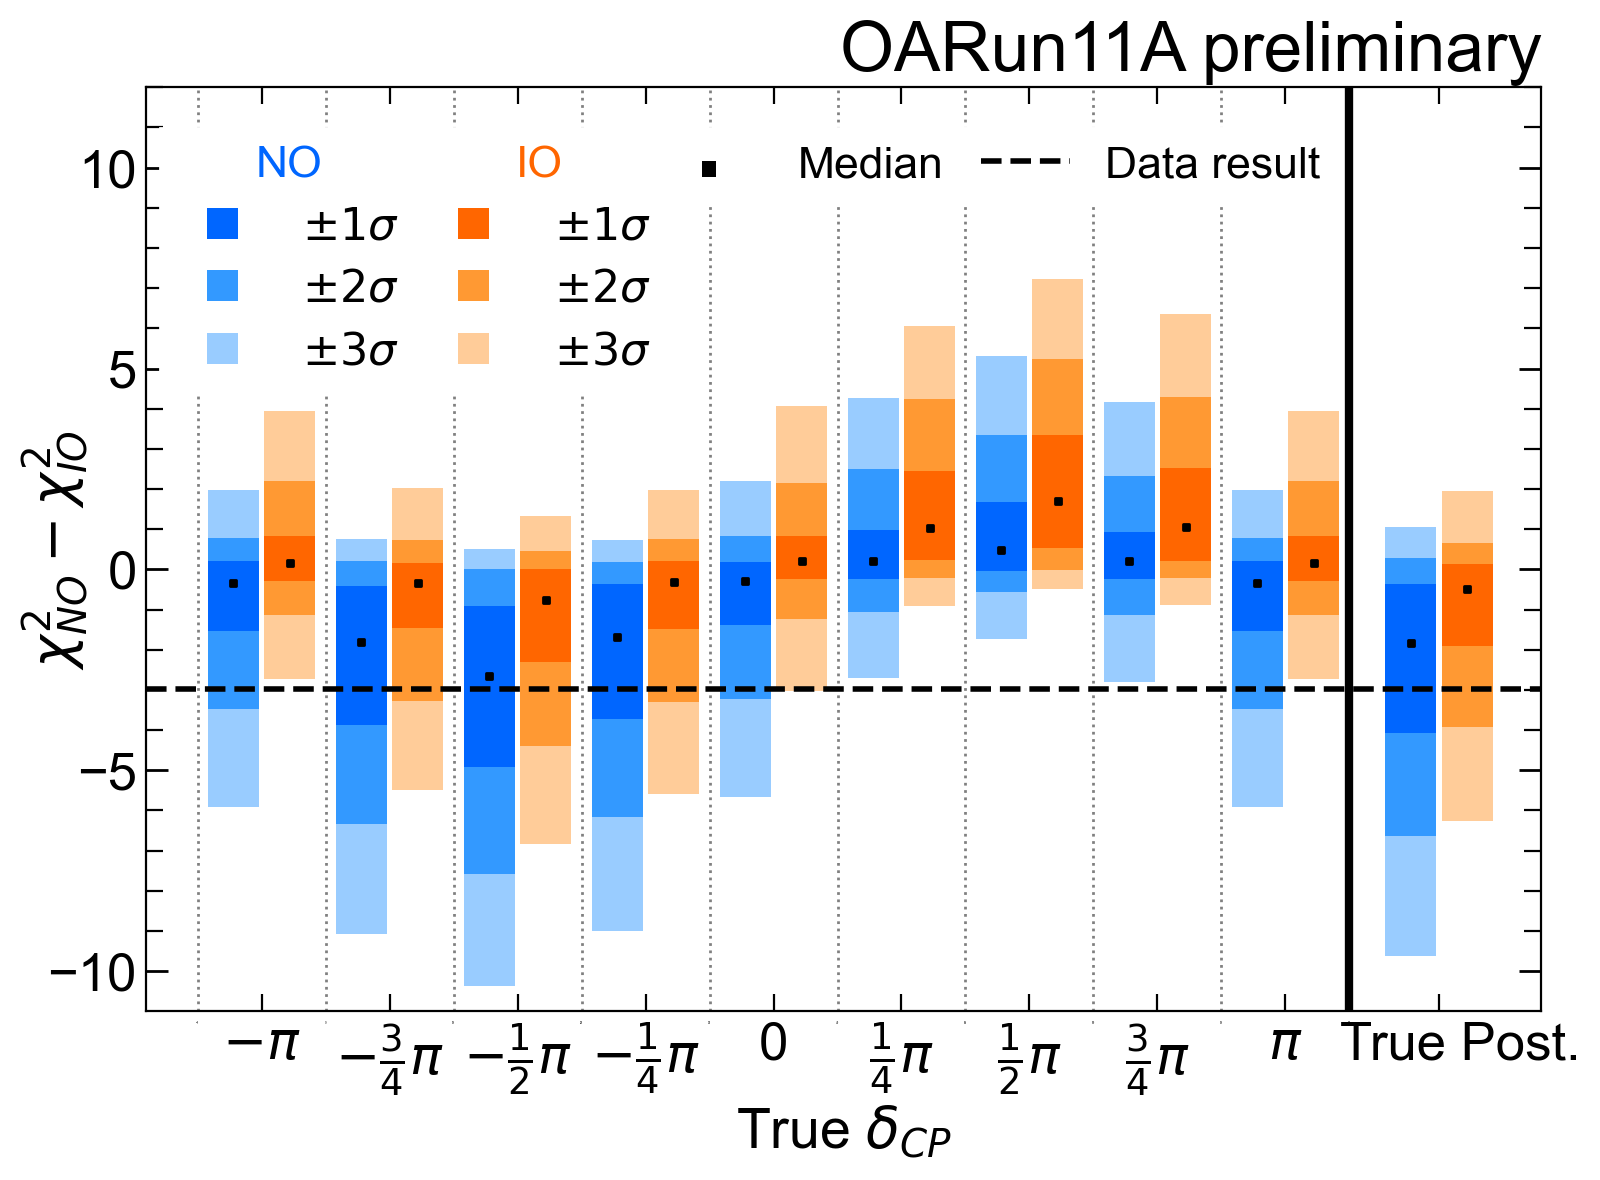

In [31]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


basename_directory = f"MargTemplates_DataFit_OA2023_mh_400k_p-theta"
file_pattern = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}/marg*.root"
grid_x, avnllh_df, param_name_x = load_1D_array(file_pattern)
avnllh_df = avnllh_df.reshape(avnllh_df.size//2, 2)

dchi2_df = 2*(avnllh_df[:, 0] - avnllh_df[:, 1])

#Labels of inputs files containing central percentiles
true_param_values = ["3.14159265359", "-2.35619449019", "-1.57079632679", "-0.785398163397", 
          "0.0",  "0.785398163397", "1.57079632679", "2.35619449019", "3.14159265359", "HC"]

param_name = 'delta'

dx = 2
fig, ax = plt.subplots(1)
for i in range(len(true_param_values)):
    step = 0
    if i==len(true_param_values)-1:
        step=2
    
    mediana_nh, sigmas_left_nh, sigmas_right_nh = read_percentiles_mo(true_param_values[i], 0)
    mediana_ih, sigmas_left_ih, sigmas_right_ih = read_percentiles_mo(true_param_values[i], 1)
    _ = make_error_box(ax, dx+10*i-0.2+step, mediana_nh, sigmas_left_nh, sigmas_right_nh, dx=dx, colorset=colorset[0])
    _ = make_error_box(ax, dx+10*i+2*dx+0.2+step, mediana_ih, sigmas_left_ih, sigmas_right_ih, dx=dx, colorset=colorset[1])


line_data = plt.axhline(dchi2_df, color="black", linewidth=2, ls='--') 

# Position of ticks on the x axis
major_positions = np.arange(-1, 91, 10)
minor_positions = np.arange(-1, 91, 10) + 5
minor_positions[-1] = major_positions[-1] + 5 + step

plt.axvline(major_positions[-1], color="black") 


minor_tick_labels = [r"$-\pi$", r"$-\frac{3}{4}\pi$", r"$-\frac{1}{2}\pi$", r"$-\frac{1}{4}\pi$","0", 
                    r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$",r"$\frac{3}{4}\pi$", r"$\pi$", "   True Post."]

ax.set_xticks(major_positions, minor=False)
plt.xticks(fontsize=0)
plt.yticks(fontsize=19)
ax.tick_params(axis='x', which='major', length=0, width=0)
ax.tick_params(axis='y', which='major', length=8, width=1)

ax.set_xticks(minor_positions, minor=True)
ax.tick_params(which='minor', length=5, width=1)

ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, size=19)

plt.grid(False)
plt.grid(axis='x', linestyle='dotted', which='major', color='gray', linewidth=0.99)


plt.xlim(major_positions[0]-4, major_positions[-1]+10+step+3)


#legend_elements = [Patch(facecolor=colorset[0][0], label='NO $\pm 1\sigma$'), 
#                   Patch(facecolor=colorset[0][1], label='NO $\pm 2\sigma$'),
#                   Patch(facecolor=colorset[0][2], label='NO $\pm 3\sigma$')]

rect1sigma, rect2sigma, rect3sigma, rectmed_black = get_bars(colorset[0])
legend1 = ax.legend( (rect1sigma[0], rect2sigma[0], rect3sigma[0]), (r'$ \pm 1\sigma$', '$\pm 2\sigma$', '$\pm 3\sigma$'), 
           handler_map={rect1sigma[0]: HandlerSquare(), rect2sigma[0]: HandlerSquare(), rect3sigma[0]: HandlerSquare()}, 
           frameon=True, facecolor='white', edgecolor='white', framealpha=1,bbox_to_anchor=(0.21, 0.98), fontsize=16)

ax.add_artist(legend1)
legend1.set_title("NO")
legend1.get_title().set_color(darkblue)
legend1.get_title().set_size(16)

rect1sigma, rect2sigma, rect3sigma, rectmed_black = get_bars(colorset[1])
legend2 = ax.legend( (rect1sigma[0], rect2sigma[0], rect3sigma[0]), (r'$ \pm 1\sigma$', '$\pm 2\sigma$', '$ \pm 3\sigma$'), 
           handler_map={rect1sigma[0]: HandlerSquare(), rect2sigma[0]: HandlerSquare(), rect3sigma[0]: HandlerSquare()}, 
           frameon=True, facecolor='white', edgecolor='white', framealpha=1, bbox_to_anchor=(0.39, 0.98), fontsize=16)

legend2.set_title("IO")
legend2.get_title().set_color(darkorange)
legend2.get_title().set_size(16)
ax.add_artist(legend2)


legend3 = ax.legend( (rectmed_black[0], rectmed_black[0]), ('Median', 'Median'), 
           handler_map={rectmed_black[0]: HandlerSquare(), rectmed_black[0]: HandlerSquare()})

# Extract the first legend entry from legend2
entry_to_save = legend3.legend_handles[0]

# Create a new legend (legend2) with the extracted entry
legend3 = ax.legend([entry_to_save], [legend3.texts[0].get_text()], handler_map={type(entry_to_save): HandlerSquare_small()},
                   frameon=True, facecolor='white', edgecolor='white', framealpha=1,bbox_to_anchor=(0.60, 0.98), fontsize=16)

ax.add_artist(legend3)

legend4 = ax.legend([line_data], ['Data result'], frameon=True, facecolor='white', edgecolor='white', 
                    framealpha=1,bbox_to_anchor=(0.72, 0.98), fontsize=16, loc='upper center')

ax.add_artist(legend4)

show_minor_ticks(ax, axis='y')


ax.set_ylabel(r"$ \chi^2_{NO} - \chi^2_{IO}$", size=20)
ax.set_xlabel(r"True $\delta_{CP}$", size=20)
ax.yaxis.set_label_coords(-0.04, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
plt.ylim(-11, 12)
ax.set_title( tag, loc='right' )

fig.savefig(f'{outputs_dir}/plots/{dir_ver}/pvalues/MO_pvalues_main_corrected3sigma.pdf', bbox_inches='tight')


In [37]:
def sinttt_to_sintttt(x):
    return 4*x*(1-x)

In [38]:
major_positions

array([-1,  9, 19, 29, 39, 49, 59, 69, 79, 89])

0.9744
0.9856000000000001
0.9936000000000001
0.9984
1.005


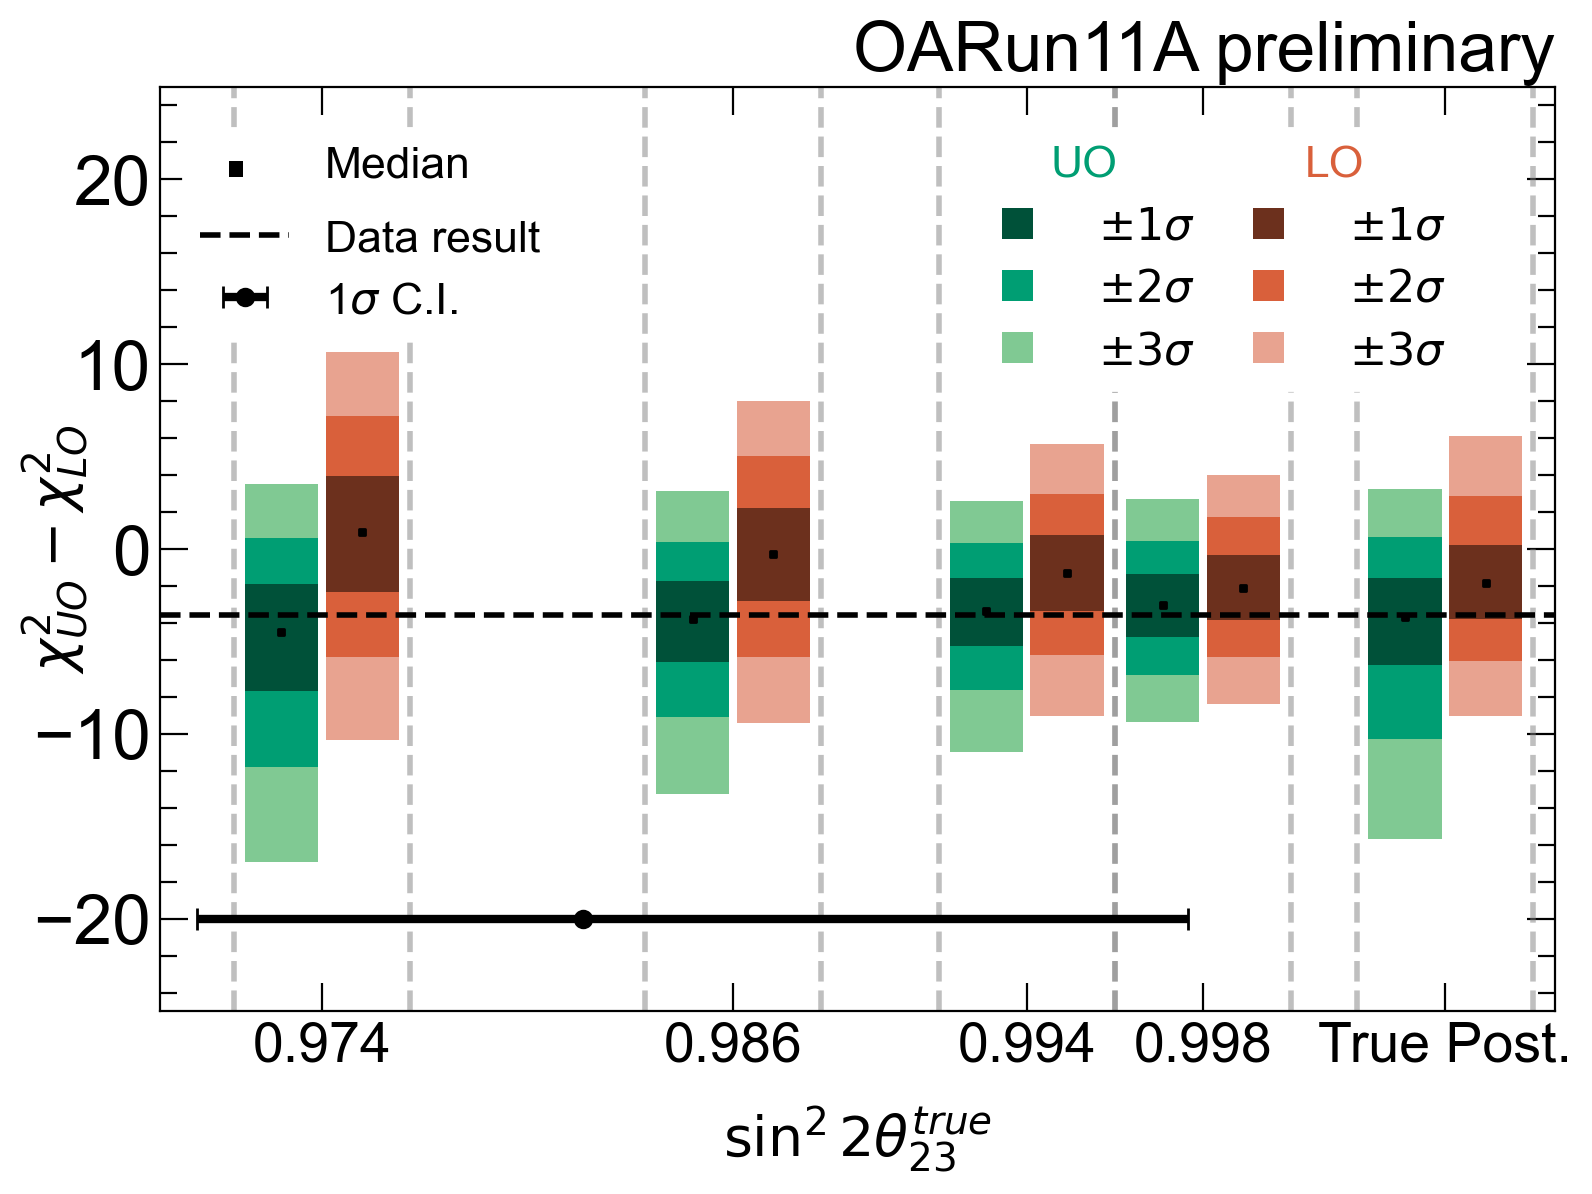

In [58]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sin223_ci = [[sinttt_to_sintttt(0.568) - 0.971], [0.998 - sinttt_to_sintttt(0.568)]]
sin223_bf = sinttt_to_sintttt(0.568)
param_name = 'sin223'
prof = False
prior = 's2223'
dchi2_octant_df = np.load(f"{outputs_dir}/files/{dir_ver}/pvalues/Octant_percentiles_statistics_data_result_prof{prof}_flat{prior}.npy")

octant_pairs = [[0.42, 0.58], [0.44, 0.56], [0.46, 0.54], [0.48, 0.52], ['HFC_LO', 'HFC_UO']]

dx = 0.001
fig, ax = plt.subplots()
major_positions = []
d = 0.0002 #shortest distance between left orange and right blue
step = 0.004
h = (step - d - 2*dx)
for i in range(len(octant_pairs)):
    mediana_lo, sigmas_left_lo, sigmas_right_lo = read_percentiles_octant(octant_pairs[i], 0, prior, prof)
    mediana_uo, sigmas_left_uo, sigmas_right_uo = read_percentiles_octant(octant_pairs[i], 1, prior, prof)

    if octant_pairs[i][0]=='HFC_LO':
        xi = 1.005
    else:
        xi = sinttt_to_sintttt(octant_pairs[i][0]) #dx+step*i-d/2
    _ = make_error_box(ax, xi-dx-d/2, mediana_uo, sigmas_left_uo, sigmas_right_uo, dx=dx, colorset=colorset[2])
    _ = make_error_box(ax, xi+dx+d/2, mediana_lo, sigmas_left_lo, sigmas_right_lo, dx=dx, colorset=colorset[3])
    print(xi)
    major_positions.append(xi)
    plt.axvline(xi-2*dx-2*d, color='grey', ls='--', linewidth=2, alpha=0.5)
    plt.axvline(xi+2*dx+2*d, color='grey', ls='--', linewidth=2, alpha=0.5)
    
major_positions = np.array(major_positions)
minor_positions = (major_positions[1]-major_positions[0])/2 + np.array(major_positions)

line_data = plt.axhline(dchi2_octant_df, color="black", linewidth=2, ls='--', label='Data result') 

errorbar = plt.errorbar([sin223_bf], [-20], xerr=sin223_ci, fmt='o', color='black', capsize=4, label='1$\sigma$ C.I.')


major_tick_labels = [
    np.round(sinttt_to_sintttt(octant_pair[0]), 3) if octant_pair[0] != 'HFC_LO' else 'True Post.'
    for octant_pair in octant_pairs
]

plt.xlim(0.97, 1.008)
#print(major_positions[-1])
ax.set_xticks(major_positions, minor=False)
ax.set_xticklabels(major_tick_labels, size=20)


#ax.tick_params(axis='x', which='major', length=0, width=0)
#ax.tick_params(axis='y', which='major', length=8, width=1)
#ax.tick_params(which='minor', length=5, width=1)
#plt.grid(False)
#plt.grid(axis='x', linestyle='dotted', which='major', color='gray', linewidth=0.99)



rect1sigma, rect2sigma, rect3sigma, rectmed_black = get_bars(colorset[2])
legend1 = ax.legend( (rect1sigma[0], rect2sigma[0], rect3sigma[0]), (r'$ \pm 1\sigma$', '$\pm 2\sigma$', '$\pm 3\sigma$'), 
           handler_map={rect1sigma[0]: HandlerSquare(), rect2sigma[0]: HandlerSquare(), rect3sigma[0]: HandlerSquare()}, 
           frameon=True, facecolor='white', edgecolor='white', framealpha=1,bbox_to_anchor=(0.77, 0.98), fontsize=16, loc='upper right')

ax.add_artist(legend1)
legend1.set_title("UO")
legend1.get_title().set_color(colorset[2][1])
legend1.get_title().set_size(16)

rect1sigma, rect2sigma, rect3sigma, rectmed_black = get_bars(colorset[3])
legend2 = ax.legend( (rect1sigma[0], rect2sigma[0], rect3sigma[0]), (r'$ \pm 1\sigma$', '$\pm 2\sigma$', '$ \pm 3\sigma$'), 
           handler_map={rect1sigma[0]: HandlerSquare(), rect2sigma[0]: HandlerSquare(), rect3sigma[0]: HandlerSquare()}, 
           frameon=True, facecolor='white', edgecolor='white', framealpha=1, bbox_to_anchor=(0.95, 0.98), fontsize=16, loc='upper right')


legend2.set_title("LO")
legend2.get_title().set_color(colorset[3][1])
legend2.get_title().set_size(16)
ax.add_artist(legend2)


legend3 = ax.legend( (rectmed_black[0], rectmed_black[0]), ('Median', 'Median'), 
           handler_map={rectmed_black[0]: HandlerSquare(), rectmed_black[0]: HandlerSquare()})

# Extract the first legend entry from legend2
entry_to_save = legend3.legend_handles[0]

# Create a new legend (legend2) with the extracted entry
legend3 = ax.legend([entry_to_save], [legend3.texts[0].get_text()], handler_map={type(entry_to_save): HandlerSquare_small()},
                   frameon=True, facecolor='white', edgecolor='white', framealpha=1,bbox_to_anchor=(0.0, 0.98), fontsize=16, loc='upper left')

ax.add_artist(legend3)

legend4 = ax.legend(handles=[line_data, errorbar], frameon=True, facecolor='white', edgecolor='white', 
                    framealpha=1,bbox_to_anchor=(0.00, 0.90), fontsize=16, loc='upper left',)

ax.add_artist(legend4)

show_minor_ticks(ax, axis='y')


ax.set_ylabel(r"$ \chi^2_{UO} - \chi^2_{LO}$", size=20)
ax.set_xlabel(r"$\sin^2 2\theta^{true}_{23}$", size=20)
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
plt.ylim(-25, 25)
ax.set_title( tag, loc='right' )

fig.savefig(f'{outputs_dir}/plots/{dir_ver}/pvalues/Octant_pvalues_main.pdf', bbox_inches='tight')


In [16]:
import osc_prob

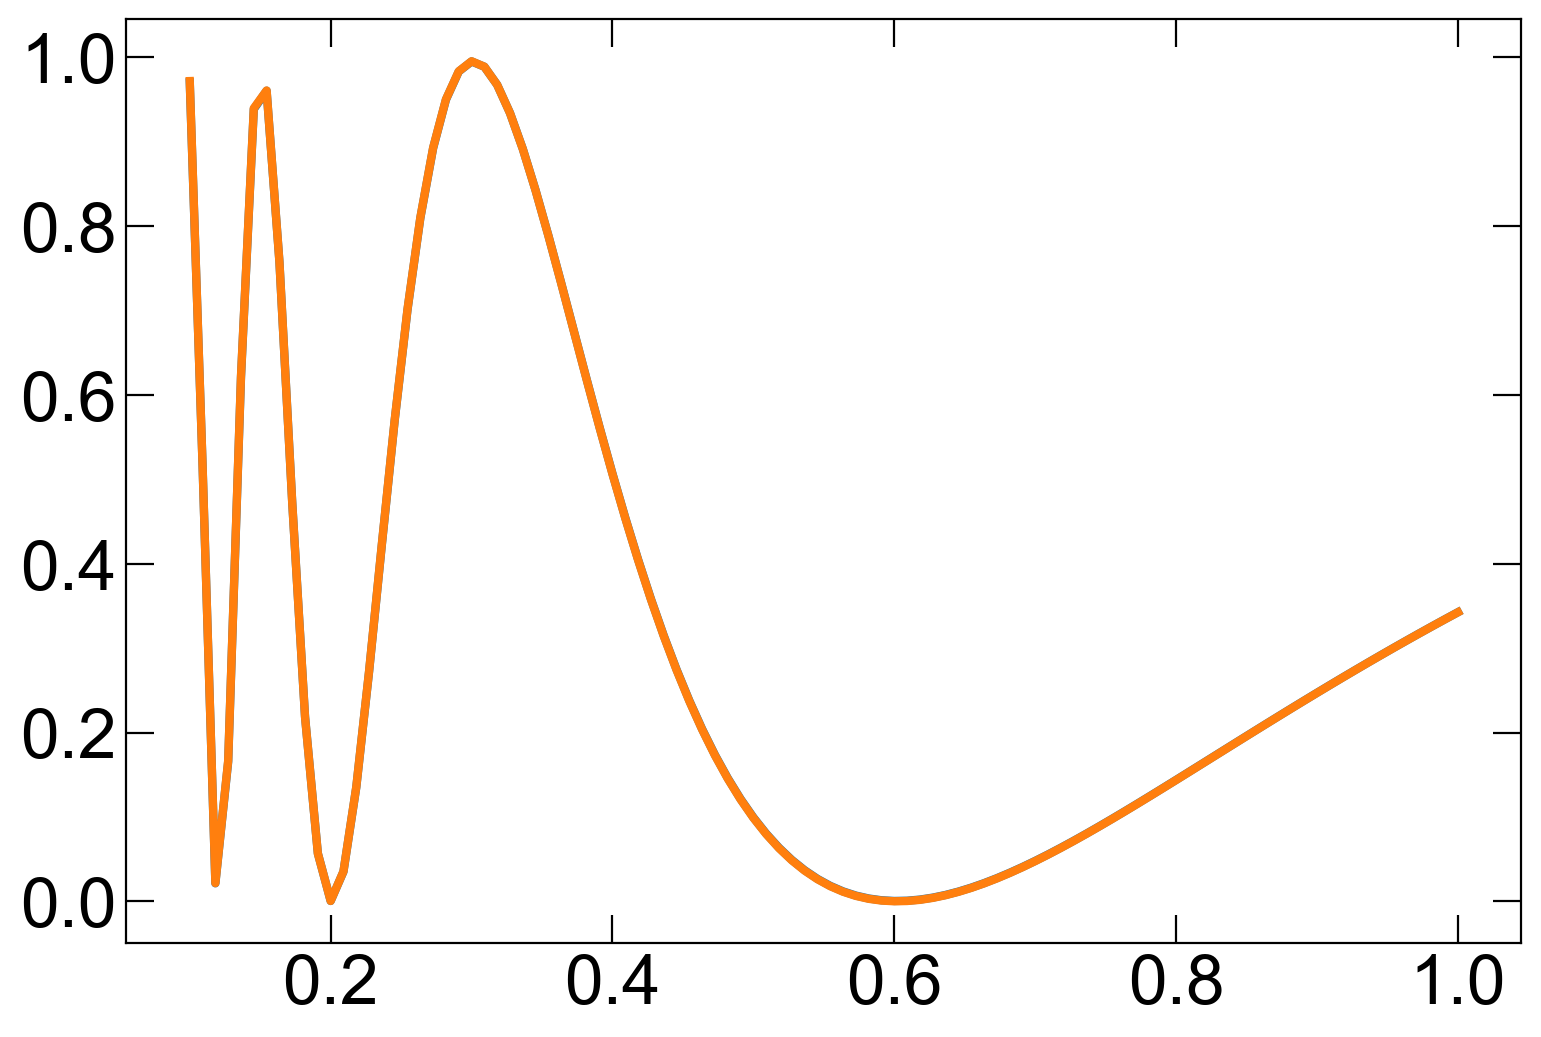

In [33]:
energy = np.linspace(0.1, 1, 100)
val = 0.50
plt.plot(energy, osc_prob.probability_general(E=energy, beta=1, theta_23=np.arcsin(np.sqrt(val))))

val = 0.52
plt.plot(energy, osc_prob.probability_general(E=energy, beta=1, theta_23=np.arcsin(np.sqrt(val))))

In [7]:
!git add -f P_values_studies.ipynb

In [8]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	deleted:    P_values_studies.ipynb
	new file:   Pvalues_percentiles.ipynb
	new file:   Pvalues_studies.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Feldman-Cousins_main.ipynb
	modified:   PlotErrorBands.ipynb
	modified:   Plot_ToyXP_main.ipynb
	modified:   Plot_ToyXP_osc_vs_noosc.ipynb
	modified:   Plot_llh_main.ipynb
	modified:   Pvalues_percentiles.ipynb
	modified:   Save_llh_contours.ipynb
	modified:   ../analysis_scripts/plot_toyxp_main.py
	modified:   ../inputs/config_files/.ipynb_checkpoints/configuration_OA2023-checkpoint.yaml
	modified:   ../inputs/config_files/.ipynb_checkpoints/configuration_OA2024-checkpoint.yaml
	modified:   ../inputs/config_files/.ipynb_checkpoints/configuration_OA2024_sensstudy-che

In [9]:
!git commit -m "Improved notebook for p-values studies. Added notebook for percentiles plotting"

[main ec9447d] Improved notebook for p-values studies. Added notebook for percentiles plotting
 3 files changed, 1649 insertions(+), 1016 deletions(-)
 delete mode 100644 Notebooks/P_values_studies.ipynb
 create mode 100644 Notebooks/Pvalues_percentiles.ipynb
 create mode 100644 Notebooks/Pvalues_studies.ipynb


In [17]:
!git push

Enumerating objects: 11, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 8 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 2.93 MiB | 4.27 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To github.com:dcarabadjac/pythetatools.git
   c85e4d1..3dd12d1  main -> main
